In [1]:
# Cell 1: Imports and Configuration
import os
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torchvision.transforms.functional as TF
from pathlib import Path
import matplotlib.pyplot as plt
import nibabel as nib
from tqdm.auto import tqdm

# --- Configuration ---
CONFIG = {
    "experiment_name": "Exp02_Baseline_UNet_HalfSplit",
    "image_size": 256,
    "batch_size": 12,          # Keep 12 if your GPU handles it
    "num_workers": 0,
    "learning_rate": 1e-4,     # <--- REVERTED to the safe value
    "epochs": 100,           
    "early_stopping_patience": 30,
    "checkpoint_interval": 10, 
    "seed": 42,
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    # Paths
    "manifest_path": "../data/UT-EndoMRI/D2_Half_Split/d2_half_split_manifest.csv",
    "data_root": "../data/UT-EndoMRI/D2_Half_Split",
    "save_dir": "../models/exp02_baseline_half_split"
}

# Create save directory
Path(CONFIG["save_dir"]).mkdir(parents=True, exist_ok=True)
(Path(CONFIG["save_dir"]) / "checkpoints").mkdir(parents=True, exist_ok=True)

print(f"Running {CONFIG['experiment_name']} on {CONFIG['device']}")

Running Exp02_Baseline_UNet_HalfSplit on cuda


In [2]:
# Cell 2

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed(CONFIG["seed"])

In [3]:
# Cell 3

class OvaryDataset(Dataset):
    def __init__(self, root_dir, manifest_path, split, image_size=256, augment=False):
        self.root_dir = Path(root_dir)
        self.df = pd.read_csv(manifest_path)
        
        # Filter by split (Using the logic: Fold 0=Test, Fold 1=Val, Fold 2-4=Train)
        self.df = self.df[self.df['split'] == split].reset_index(drop=True)
        
        self.image_size = image_size
        self.augment = augment
        self.samples = [] 
        
        print(f"Initializing {split.upper()} dataset from {self.root_dir.name}...")
        
        for idx, row in self.df.iterrows():
            # Robust path finding
            img_name = Path(row['t2fs_path']).name
            msk_name = Path(row['ov_path']).name
            
            img_p = self.root_dir / img_name
            msk_p = self.root_dir / msk_name
            
            if not img_p.exists():
                print(f"  WARNING: File not found {img_p}")
                continue
                
            # Pre-scan for valid slices
            try:
                msk_vol = nib.load(str(msk_p)).get_fdata()
                z_sums = np.sum(msk_vol, axis=(0, 1))
                valid_slices = np.where(z_sums > 0)[0]
                
                for z in valid_slices:
                    self.samples.append({
                        'img_path': str(img_p),
                        'msk_path': str(msk_p),
                        'slice_idx': z,
                        'pid': row['pid']
                    })
            except Exception as e:
                print(f"  Error loading {row['pid']}: {e}")
                
        print(f"  Found {len(self.samples)} positive slices.")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        info = self.samples[idx]
        
        # Load Volumes
        img_vol = nib.load(info['img_path']).get_fdata()
        msk_vol = nib.load(info['msk_path']).get_fdata()
        
        # Extract Slice
        z = info['slice_idx']
        img = img_vol[:, :, z]
        msk = msk_vol[:, :, z]
        
        # 1. Robust Min-Max Normalization (Standard Preprocessing)
        p1 = np.percentile(img, 1)
        p99 = np.percentile(img, 99)
        img = np.clip(img, p1, p99)
        img = (img - img.min()) / (img.max() - img.min() + 1e-8)
        
        # 2. Binarize Mask
        msk = (msk > 0).astype(np.float32)
        
        # 3. To Tensor (H, W) -> (C, H, W)
        # Nibabel is (W, H), transpose to (H, W)
        img = torch.from_numpy(img.T).float().unsqueeze(0)
        msk = torch.from_numpy(msk.T).float().unsqueeze(0)
        
        # 4. Resize
        img = TF.resize(img, [self.image_size, self.image_size], interpolation=T.InterpolationMode.BILINEAR, antialias=True)
        msk = TF.resize(msk, [self.image_size, self.image_size], interpolation=T.InterpolationMode.NEAREST, antialias=True)
        
        # 5. Augmentation
        if self.augment:
            # Random Rotation
            angle = random.uniform(-25, 25)
            img = TF.rotate(img, angle, interpolation=T.InterpolationMode.BILINEAR)
            msk = TF.rotate(msk, angle, interpolation=T.InterpolationMode.NEAREST)
            
            # Random Translation (+/- 10%)
            max_shift = int(self.image_size * 0.1)
            t_x = random.randint(-max_shift, max_shift)
            t_y = random.randint(-max_shift, max_shift)
            img = TF.affine(img, angle=0, translate=(t_x, t_y), scale=1.0, shear=0, interpolation=T.InterpolationMode.BILINEAR)
            msk = TF.affine(msk, angle=0, translate=(t_x, t_y), scale=1.0, shear=0, interpolation=T.InterpolationMode.NEAREST)
            
        return img, msk

# Instantiate DataLoaders
train_ds = OvaryDataset(CONFIG["data_root"], CONFIG["manifest_path"], split='train', augment=True)
val_ds = OvaryDataset(CONFIG["data_root"], CONFIG["manifest_path"], split='val', augment=False)

train_loader = DataLoader(train_ds, batch_size=CONFIG["batch_size"], shuffle=True, num_workers=CONFIG["num_workers"])
val_loader = DataLoader(val_ds, batch_size=CONFIG["batch_size"], shuffle=False, num_workers=CONFIG["num_workers"])

Initializing TRAIN dataset from D2_Half_Split...
  Found 101 positive slices.
Initializing VAL dataset from D2_Half_Split...
  Found 38 positive slices.


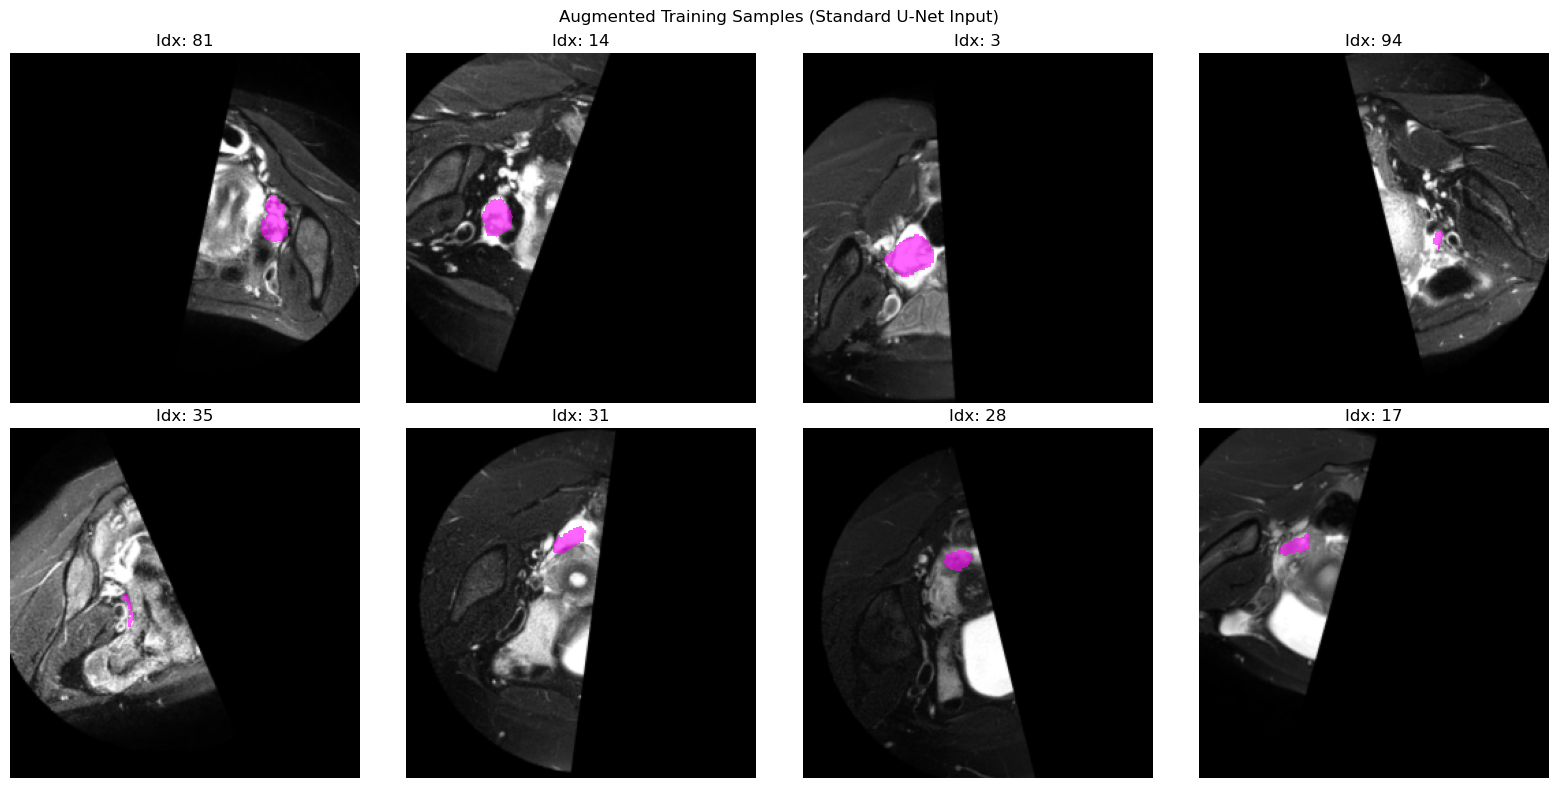

In [4]:
# Cell 4

# Pull a few samples
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

indices = [random.randint(0, len(train_ds)-1) for _ in range(8)]

for ax, idx in zip(axes, indices):
    img, msk = train_ds[idx]
    
    img_np = img.squeeze().numpy()
    msk_np = msk.squeeze().numpy()
    
    ax.imshow(img_np, cmap='gray', origin='lower')
    # Overlay mask in red/pink
    masked_overlay = np.ma.masked_where(msk_np == 0, msk_np)
    ax.imshow(masked_overlay, cmap='spring', alpha=0.6, origin='lower')
    
    ax.set_title(f"Idx: {idx}")
    ax.axis('off')

plt.suptitle("Augmented Training Samples (Standard U-Net Input)")
plt.tight_layout()
plt.show()

In [5]:
# Cell 5

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels=1, n_classes=1):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(64, 128))
        self.down2 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(128, 256))
        self.down3 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(256, 512))
        self.down4 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(512, 1024))
        
        self.up1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.conv1 = DoubleConv(1024, 512)
        self.up2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.conv2 = DoubleConv(512, 256)
        self.up3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv3 = DoubleConv(256, 128)
        self.up4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv4 = DoubleConv(128, 64)
        
        self.outc = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        
        x = self.up1(x5)
        x = torch.cat([x, x4], dim=1)
        x = self.conv1(x)
        
        x = self.up2(x)
        x = torch.cat([x, x3], dim=1)
        x = self.conv2(x)
        
        x = self.up3(x)
        x = torch.cat([x, x2], dim=1)
        x = self.conv3(x)
        
        x = self.up4(x)
        x = torch.cat([x, x1], dim=1)
        x = self.conv4(x)
        
        logits = self.outc(x)
        return logits

# Initialize Model
model = UNet(n_channels=1, n_classes=1).to(CONFIG["device"])
print("Model initialized.")

Model initialized.


In [6]:
# Cell 6: Loss and Optimizer (No Scheduler)

class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        inputs_sigmoid = torch.sigmoid(inputs)
        bce = F.binary_cross_entropy_with_logits(inputs, targets, reduction='mean')
        
        inputs_flat = inputs_sigmoid.view(-1)
        targets_flat = targets.view(-1)
        intersection = (inputs_flat * targets_flat).sum()
        dice_loss = 1 - (2.*intersection + smooth)/(inputs_flat.sum() + targets_flat.sum() + smooth)
        
        return bce + dice_loss

criterion = DiceBCELoss()

# Optimizer: AdamW (Good for generalization)
# We use the safe LR from Config (1e-4)
optimizer = torch.optim.AdamW(model.parameters(), lr=CONFIG["learning_rate"], weight_decay=1e-5)

print(f"Optimizer: AdamW (Constant LR={CONFIG['learning_rate']})")

Optimizer: AdamW (Constant LR=0.0001)


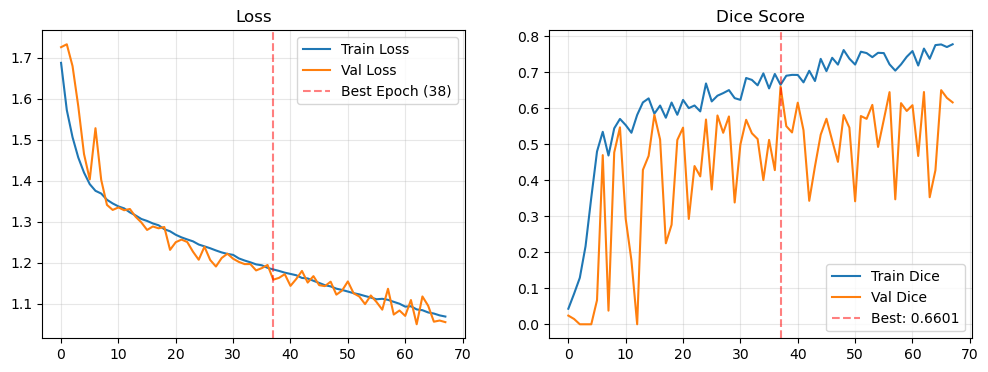

Training Complete.


In [7]:
# Cell 7: Training Loop (Constant LR, Early Stopping)
from IPython.display import clear_output

def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    epoch_loss = 0
    epoch_dice = 0
    
    for imgs, masks in tqdm(loader, desc="Train", leave=False):
        imgs, masks = imgs.to(device), masks.to(device)
        
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        
        preds = (torch.sigmoid(outputs) > 0.5).float()
        intersection = (preds * masks).sum()
        dice = (2. * intersection) / (preds.sum() + masks.sum() + 1e-8)
        epoch_dice += dice.item()
        
    return epoch_loss / len(loader), epoch_dice / len(loader)

def validate(model, loader, criterion, device):
    model.eval()
    epoch_loss = 0
    epoch_dice = 0
    
    with torch.no_grad():
        for imgs, masks in tqdm(loader, desc="Val", leave=False):
            imgs, masks = imgs.to(device), masks.to(device)
            
            outputs = model(imgs)
            loss = criterion(outputs, masks)
            epoch_loss += loss.item()
            
            preds = (torch.sigmoid(outputs) > 0.5).float()
            intersection = (preds * masks).sum()
            dice = (2. * intersection) / (preds.sum() + masks.sum() + 1e-8)
            epoch_dice += dice.item()
            
    return epoch_loss / len(loader), epoch_dice / len(loader)

def plot_training_history(history, best_epoch, best_val_dice):
    clear_output(wait=True)
    plt.figure(figsize=(12, 4))
    
    # Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    if best_epoch is not None:
        plt.axvline(x=best_epoch, color='r', linestyle='--', alpha=0.5, label=f'Best Epoch ({best_epoch+1})')
    plt.title('Loss')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # Dice Plot
    plt.subplot(1, 2, 2)
    plt.plot(history['train_dice'], label='Train Dice')
    plt.plot(history['val_dice'], label='Val Dice')
    if best_epoch is not None:
        plt.axvline(x=best_epoch, color='r', linestyle='--', alpha=0.5, label=f'Best: {best_val_dice:.4f}')
    plt.title('Dice Score')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    plt.show()

# --- Main Training Loop ---
history = {'train_loss': [], 'val_loss': [], 'train_dice': [], 'val_dice': []}
best_val_dice = 0.0
best_epoch = None
patience_counter = 0

print(f"Starting training for {CONFIG['epochs']} epochs...")

for epoch in range(CONFIG['epochs']):
    t_loss, t_dice = train_one_epoch(model, train_loader, optimizer, criterion, CONFIG["device"])
    v_loss, v_dice = validate(model, val_loader, criterion, CONFIG["device"])
    
    # NO SCHEDULER STEP HERE
    
    history['train_loss'].append(t_loss)
    history['val_loss'].append(v_loss)
    history['train_dice'].append(t_dice)
    history['val_dice'].append(v_dice)
    
    if v_dice > best_val_dice:
        best_val_dice = v_dice
        best_epoch = epoch
        save_path = Path(CONFIG["save_dir"]) / "best_model.pth"
        torch.save(model.state_dict(), save_path)
        new_best_msg = f"  >>> New Best! (Dice: {best_val_dice:.4f})"
        patience_counter = 0
    else:
        new_best_msg = ""
        patience_counter += 1
        
    if (epoch + 1) % CONFIG.get("checkpoint_interval", 10) == 0:
        ckpt_path = Path(CONFIG["save_dir"]) / "checkpoints" / f"epoch_{epoch+1}.pth"
        torch.save(model.state_dict(), ckpt_path)

    plot_training_history(history, best_epoch, best_val_dice)
    
    print(f"Epoch {epoch+1}/{CONFIG['epochs']} | "
          f"Train Loss: {t_loss:.4f} Dice: {t_dice:.4f} | "
          f"Val Loss: {v_loss:.4f} Dice: {v_dice:.4f}{new_best_msg}")
    
    if patience_counter >= CONFIG["early_stopping_patience"]:
        print(f"\nEARLY STOPPING TRIGGERED at Epoch {epoch+1}")
        break

plot_training_history(history, best_epoch, best_val_dice)
torch.save(model.state_dict(), Path(CONFIG["save_dir"]) / "last_model.pth")
print("Training Complete.")

In [ ]:
# # Cell 8: Training Curves with Best Model Indicator

# # Find the epoch with the best validation dice
# best_epoch_idx = np.argmax(history['val_dice'])
# best_epoch_val = history['val_dice'][best_epoch_idx]

# plt.figure(figsize=(12, 5))

# # Loss Plot
# plt.subplot(1, 2, 1)
# plt.plot(history['train_loss'], label='Train Loss')
# plt.plot(history['val_loss'], label='Val Loss')
# # Add vertical line
# plt.axvline(x=best_epoch_idx, color='r', linestyle='--', alpha=0.7, label=f'Best Epoch ({best_epoch_idx+1})')
# plt.title('Loss Curves')
# plt.xlabel('Epoch')
# plt.legend()
# plt.grid(True, alpha=0.3)

# # Dice Plot
# plt.subplot(1, 2, 2)
# plt.plot(history['train_dice'], label='Train Dice')
# plt.plot(history['val_dice'], label='Val Dice')
# # Add vertical line
# plt.axvline(x=best_epoch_idx, color='r', linestyle='--', alpha=0.7, label=f'Best: {best_epoch_val:.4f}')
# plt.title('Dice Score Curves')
# plt.xlabel('Epoch')
# plt.legend()
# plt.grid(True, alpha=0.3)

# plt.tight_layout()
# plt.show()

C:\Users\lytten\AppData\Local\Temp\ipykernel_22256\1614595202.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Visualizing: best_model.pth (Best Auto-Selected Model)


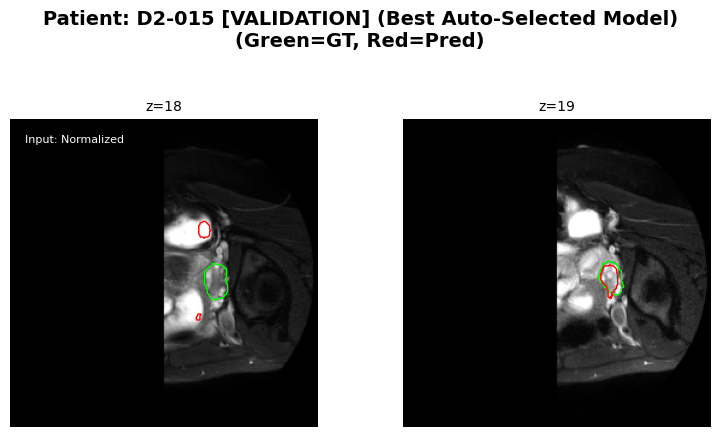

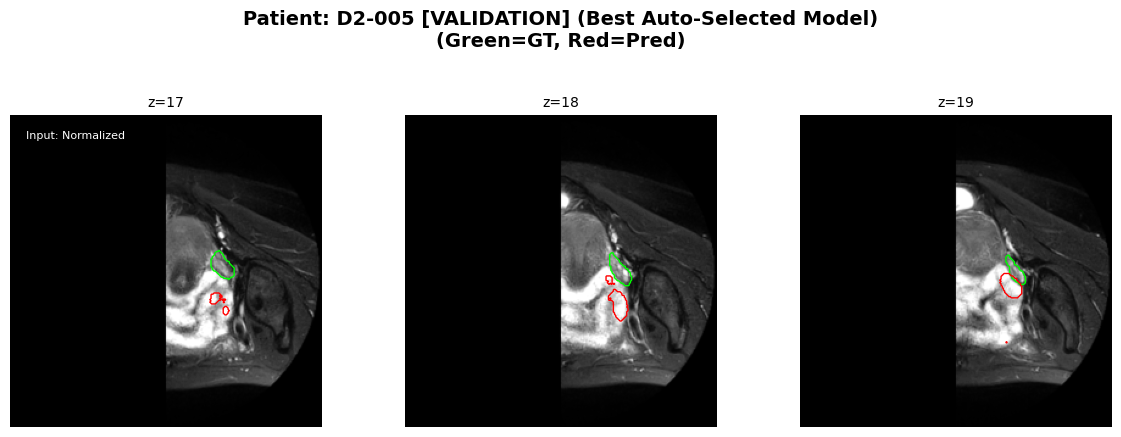

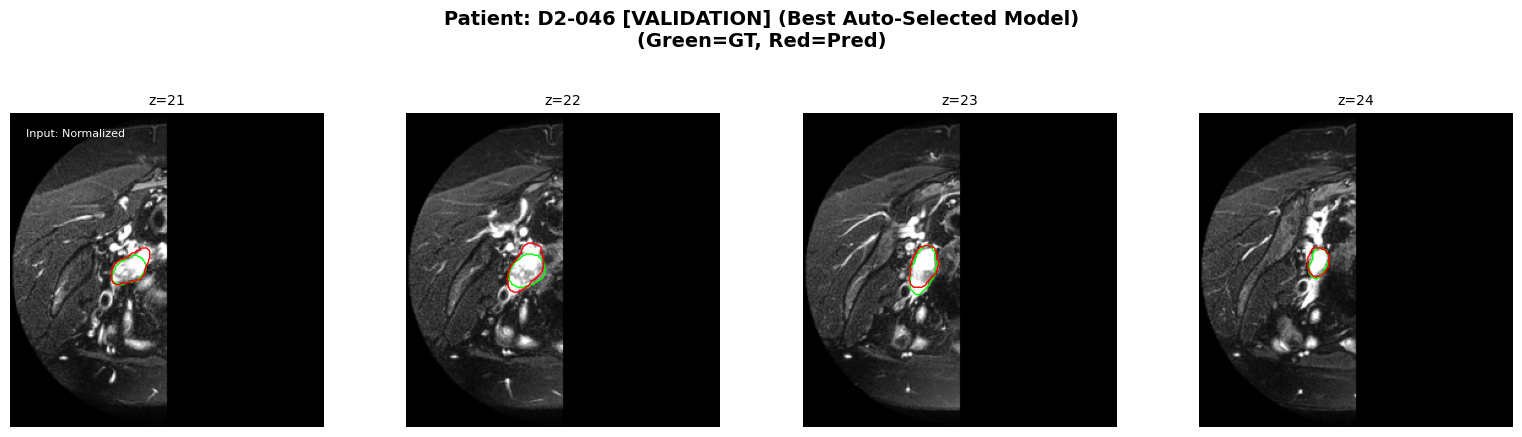

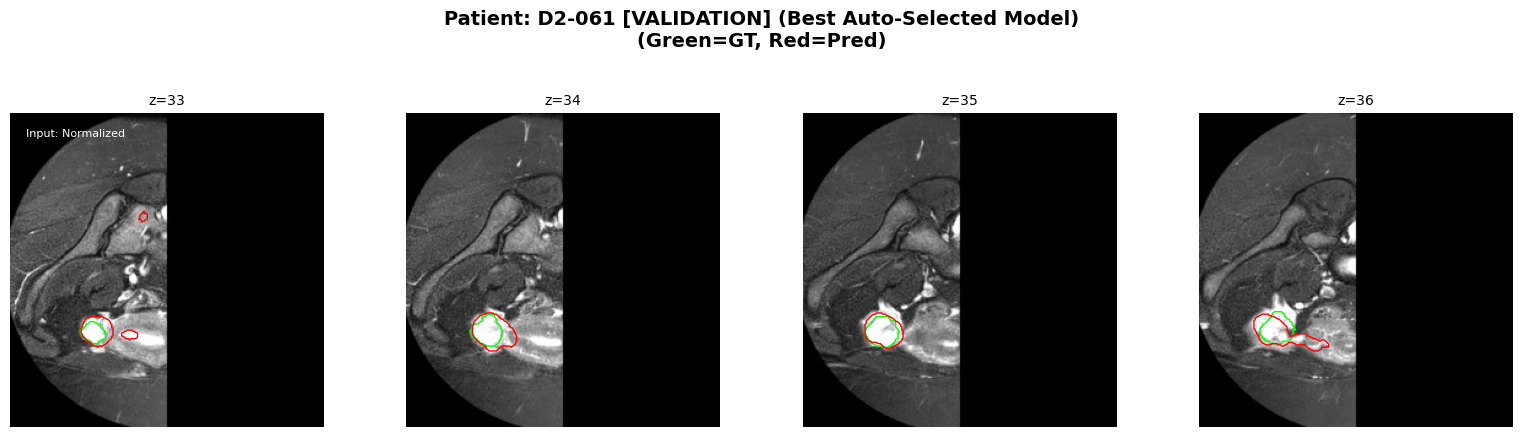

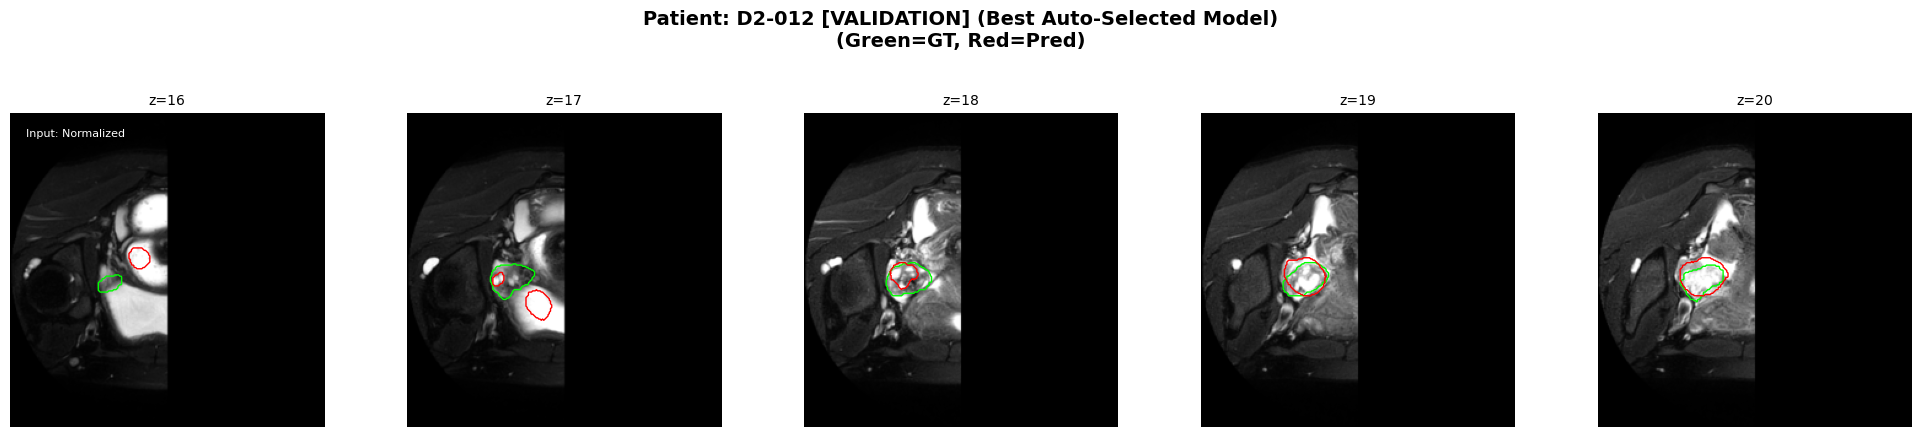

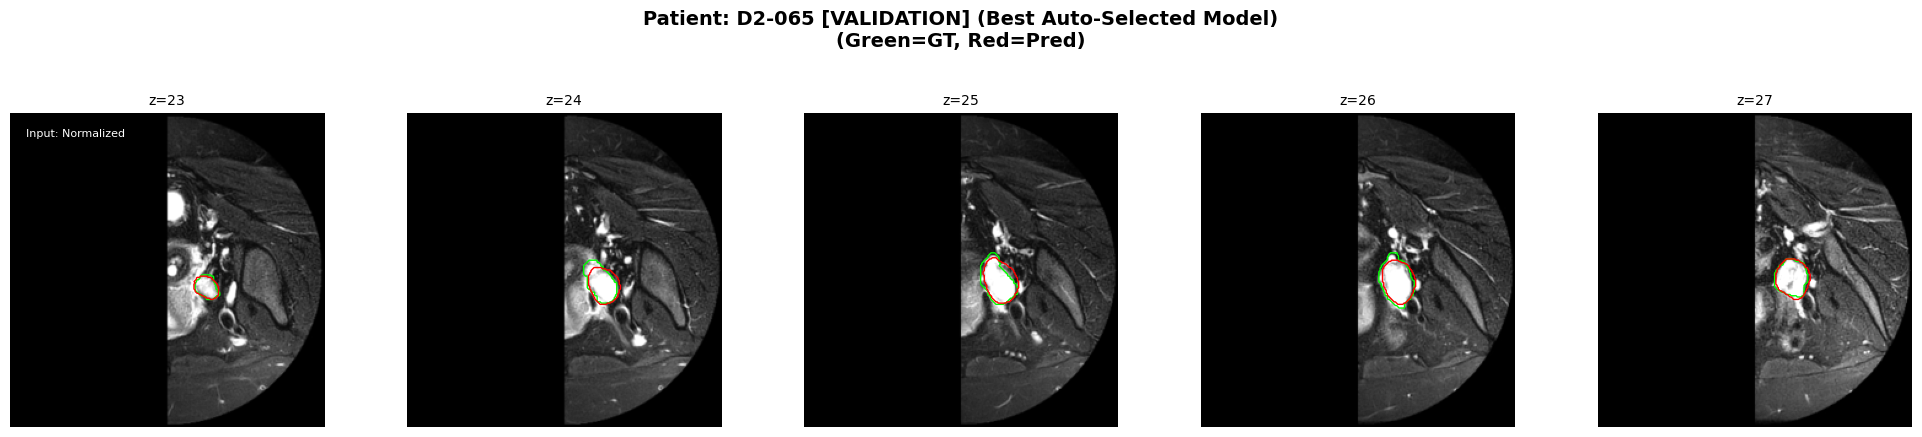

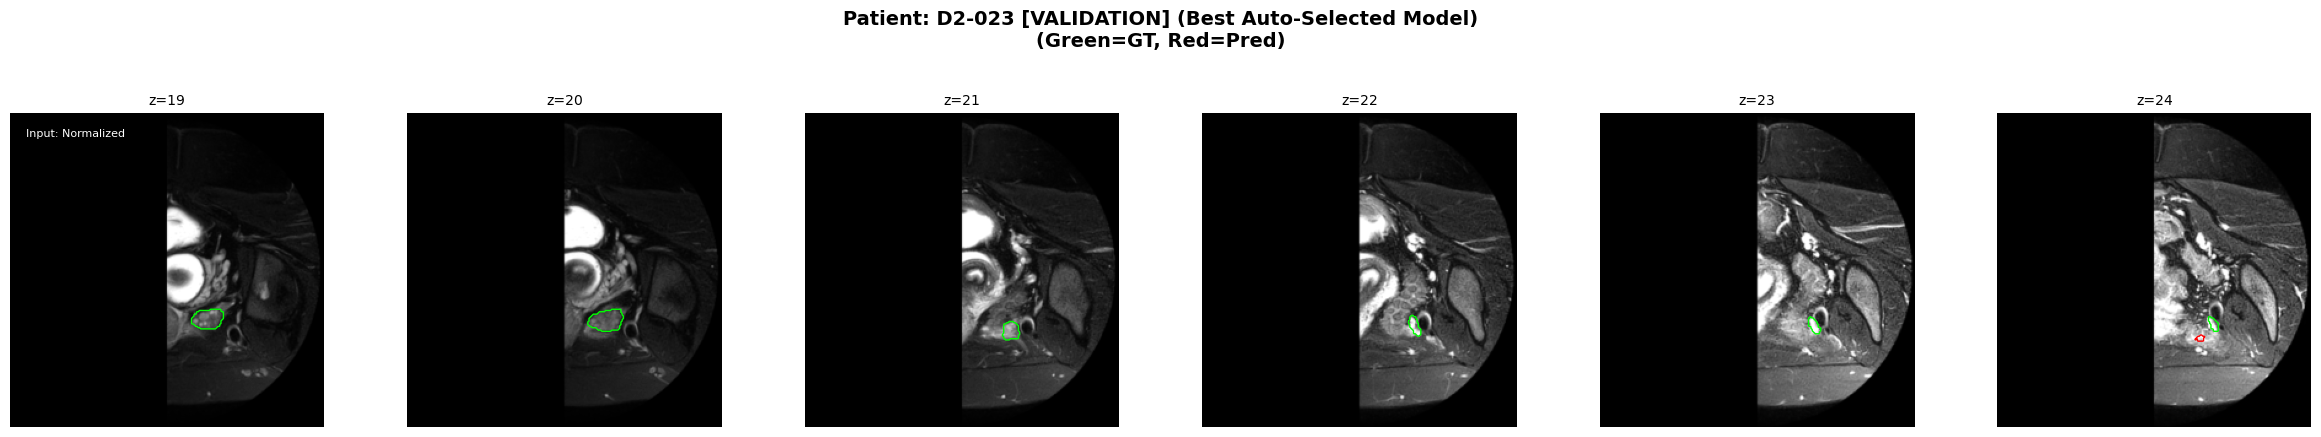

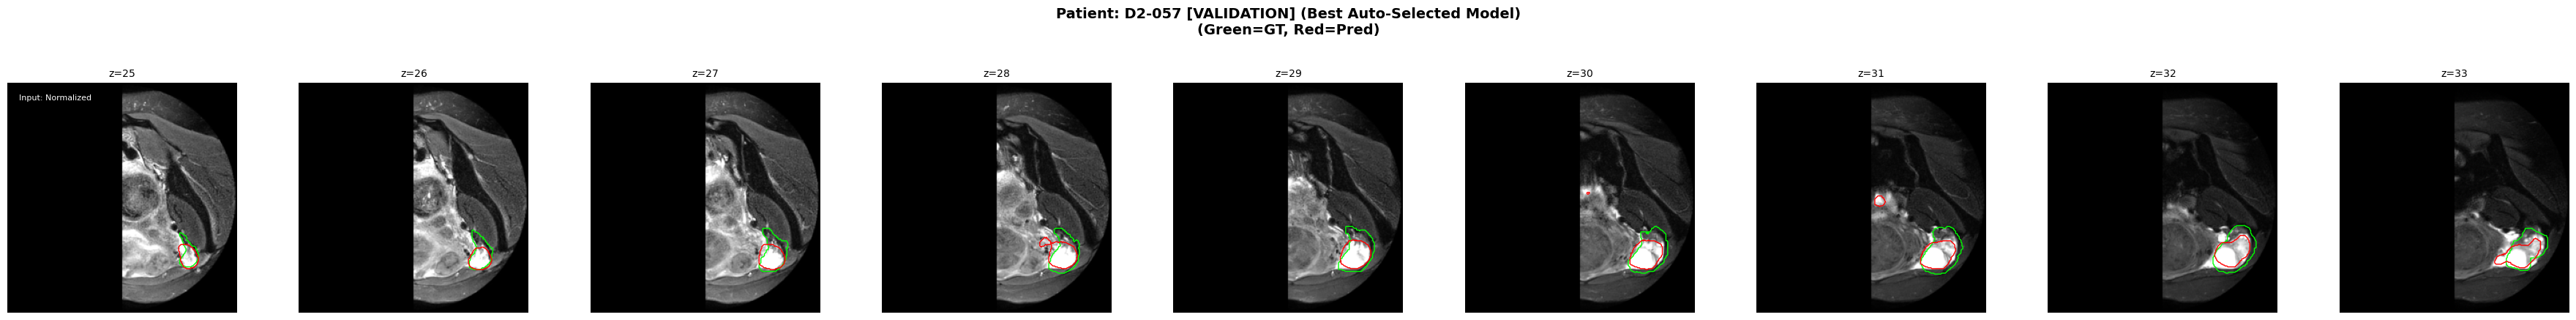

In [8]:
# Cell 9: Qualitative Analysis (Validation Set)
# Green = Ground Truth | Red = Prediction

# --- USER SETTING ---
VIEW_EPOCH = None  # Set to None for "Best Model", or an integer (e.g., 30) for a specific epoch
# --------------------

def visualize_validation_results(save_dir, dataset, device, epoch=None):
    # Determine which file to load
    if epoch is None:
        model_path = Path(save_dir) / "best_model.pth"
        title_suffix = "(Best Auto-Selected Model)"
    else:
        model_path = Path(save_dir) / "checkpoints" / f"epoch_{epoch}.pth"
        title_suffix = f"(Manual Checkpoint: Epoch {epoch})"
    
    if not model_path.exists():
        print(f"Error: Model not found at {model_path}")
        return

    # Load Model
    model = UNet(n_channels=1, n_classes=1).to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    
    print(f"Visualizing: {model_path.name} {title_suffix}")
    
    # Group by patient
    patient_indices = {}
    for i, sample in enumerate(dataset.samples):
        pid = sample['pid']
        if pid not in patient_indices:
            patient_indices[pid] = []
        patient_indices[pid].append(i)
        
    for pid, indices in patient_indices.items():
        indices.sort(key=lambda i: dataset.samples[i]['slice_idx'])
        n_slices = len(indices)
        
        fig, axes = plt.subplots(1, n_slices, figsize=(4 * n_slices, 4))
        if n_slices == 1: axes = [axes]
        
        fig.suptitle(f"Patient: {pid} [VALIDATION] {title_suffix}\n(Green=GT, Red=Pred)", y=1.08, fontsize=14, fontweight='bold')
        
        with torch.no_grad():
            for ax, ds_idx in zip(axes, indices):
                img, msk = dataset[ds_idx]
                input_tensor = img.unsqueeze(0).to(device)
                
                logits = model(input_tensor)
                pred = (torch.sigmoid(logits) > 0.5).float().cpu().squeeze().numpy()
                
                img_np = img.squeeze().numpy()
                msk_np = msk.squeeze().numpy()
                
                # Show Preprocessed Input
                ax.imshow(img_np, cmap='gray', origin='lower')
                
                # GT Contour
                if np.sum(msk_np) > 0:
                    ax.contour(msk_np, colors='lime', linewidths=1.0, levels=[0.5])
                
                # Pred Contour
                if np.sum(pred) > 0:
                    ax.contour(pred, colors='red', linewidths=1.0, levels=[0.5])
                
                slice_idx = dataset.samples[ds_idx]['slice_idx']
                if ax == axes[0]:
                    ax.text(0.05, 0.95, "Input: Normalized", transform=ax.transAxes, color='white', fontsize=8, verticalalignment='top')
                
                ax.set_title(f"z={slice_idx}", fontsize=10)
                ax.axis('off')

        plt.tight_layout()
        plt.show()

# Run Visualization
visualize_validation_results(CONFIG["save_dir"], val_ds, CONFIG["device"], epoch=VIEW_EPOCH)

C:\Users\lytten\AppData\Local\Temp\ipykernel_22256\431826444.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Initializing TEST dataset from D2_Half_Split...
  Found 38 positive slices.
Evaluating Test Set (Fold 0) - 38 slices total.
Generating 3D Scores and Visualizations...



Patients:   0%|          | 0/8 [00:00<?, ?it/s]

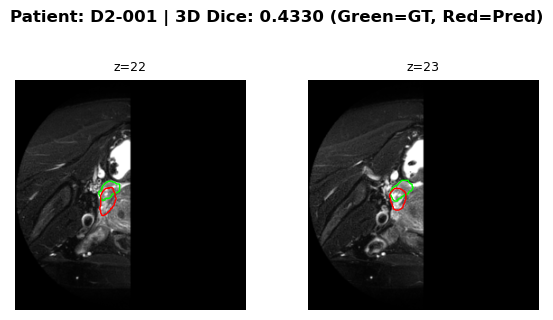

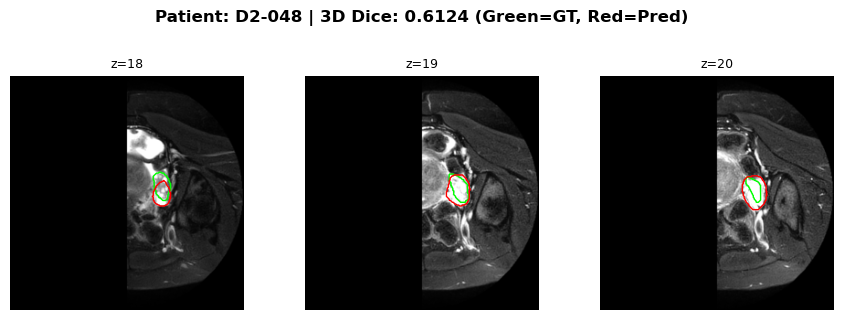

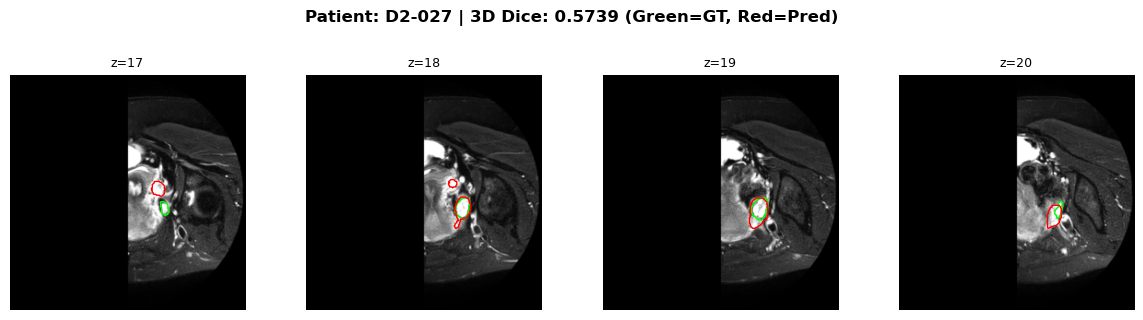

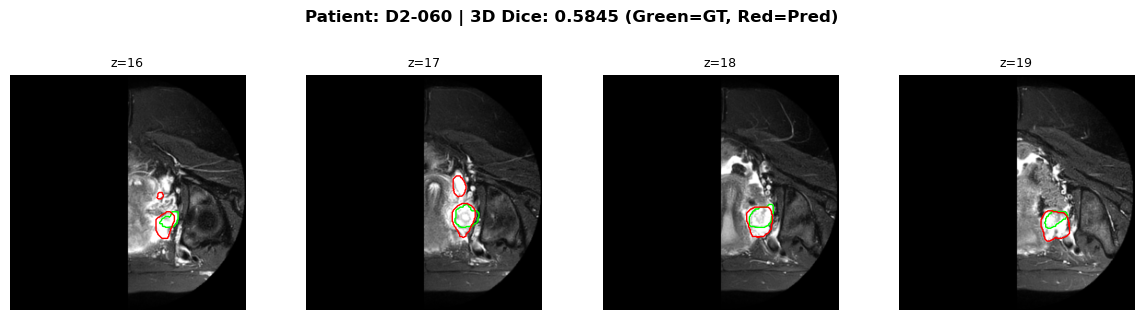

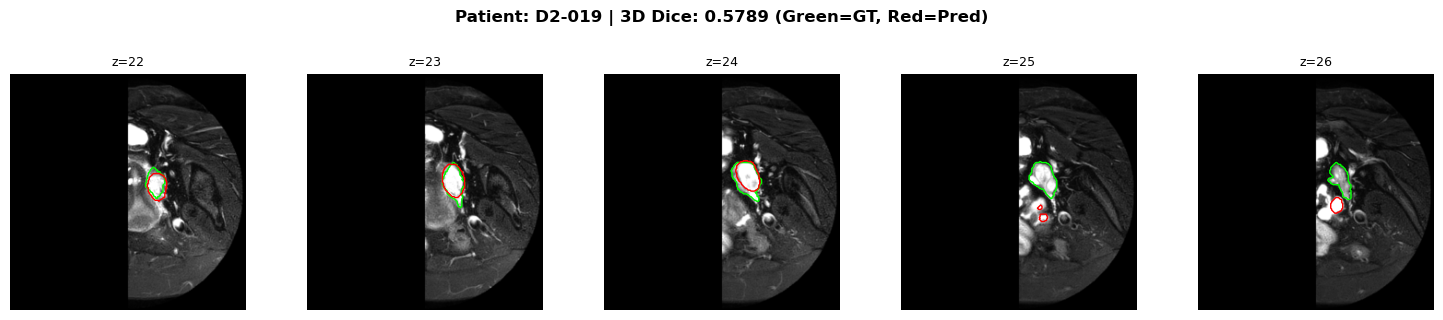

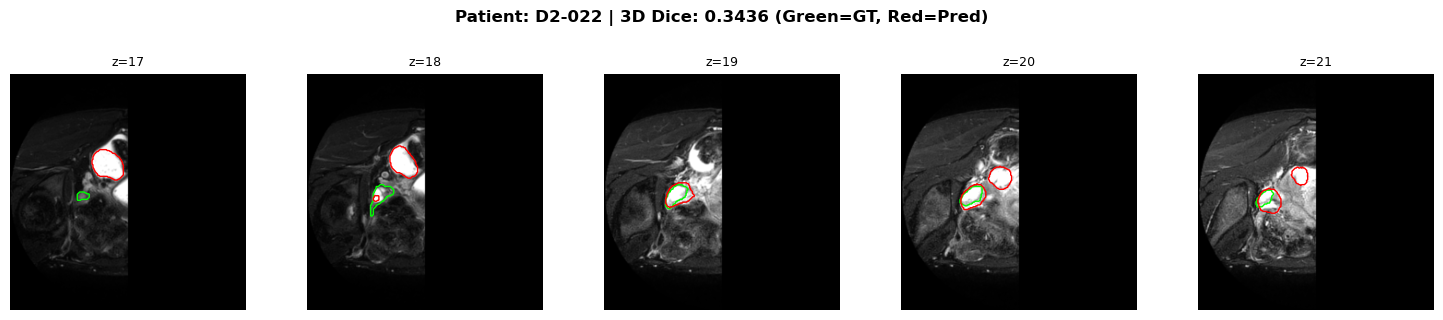

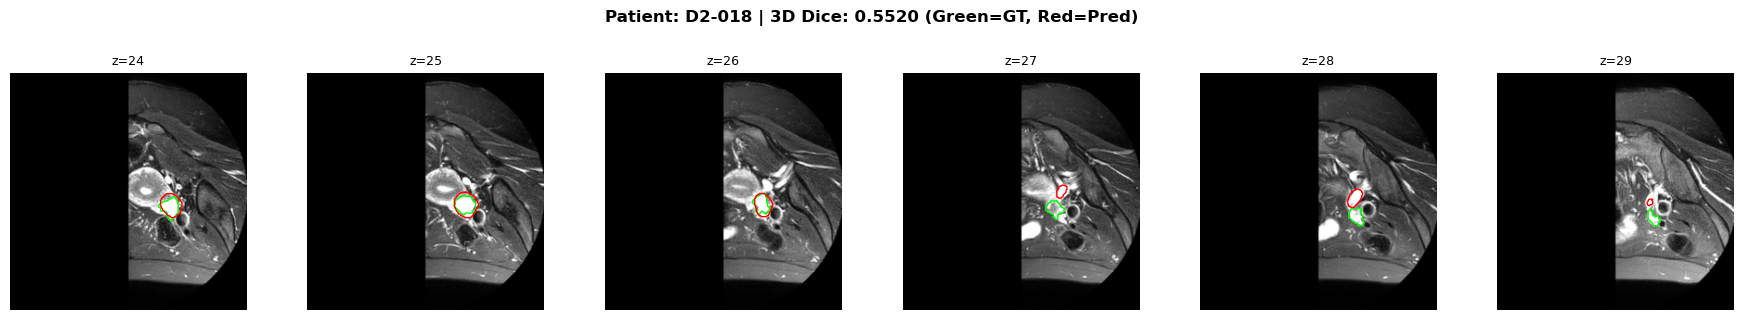

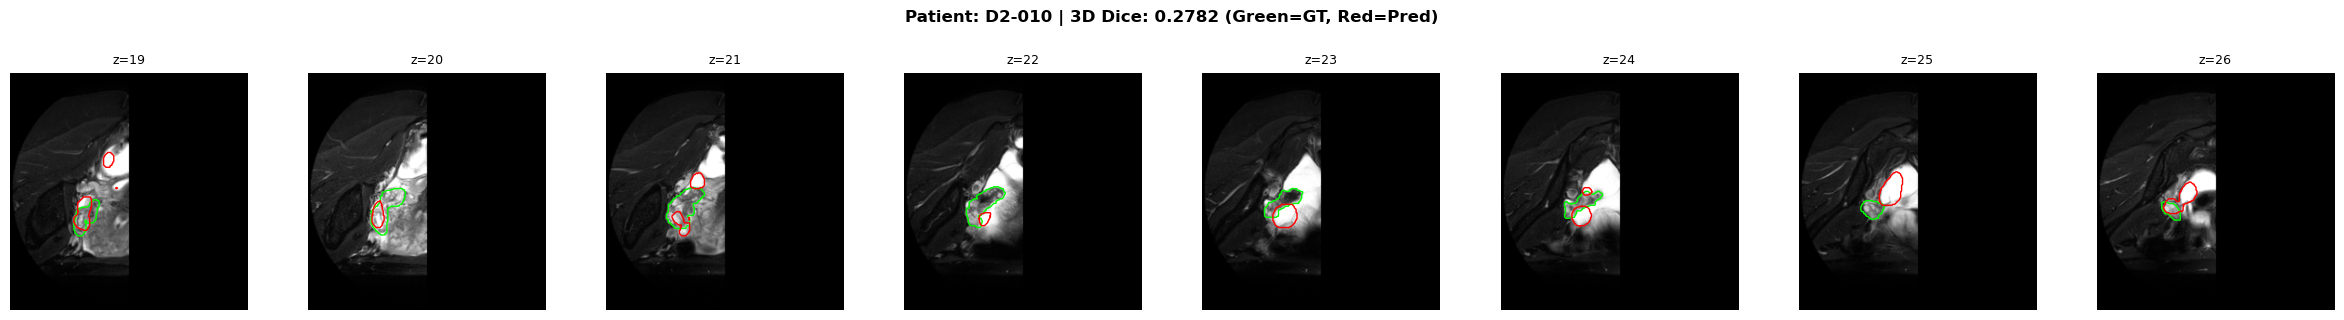


OVERALL TEST SET PERFORMANCE
Mean 3D Dice: 0.4946 ± 0.1184


In [9]:
# 10. Quantitative & Qualitative Evaluation on Test Set
# We reconstruct 3D volumes for the Test Set (Fold 0), calculate the clinical Dice score,
# and visualize the results for every patient.


def evaluate_test_set_3d(model_path, root_dir, manifest_path, device):
    # 1. Load Model
    model = UNet(n_channels=1, n_classes=1).to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    
    # 2. Load TEST Set (Fold 0)
    test_ds = OvaryDataset(root_dir, manifest_path, split='test', augment=False)
    
    print(f"Evaluating Test Set (Fold 0) - {len(test_ds)} slices total.")
    print("Generating 3D Scores and Visualizations...\n")
    
    # Group by patient
    patient_data = {}
    for i, sample in enumerate(test_ds.samples):
        pid = sample['pid']
        if pid not in patient_data:
            patient_data[pid] = []
        patient_data[pid].append(sample)
        
    patient_dice_scores = []
    
    with torch.no_grad():
        for pid, samples in tqdm(patient_data.items(), desc="Patients"):
            # Sort by slice index
            samples.sort(key=lambda x: x['slice_idx'])
            
            vol_pred = []
            vol_gt = []
            vol_imgs = [] # Keep raw images for plotting
            
            # --- Prediction Loop ---
            for sample in samples:
                img_vol = nib.load(sample['img_path']).get_fdata()
                msk_vol = nib.load(sample['msk_path']).get_fdata()
                z = sample['slice_idx']
                
                img = img_vol[:, :, z]
                msk = msk_vol[:, :, z]
                
                # Preprocessing
                p1 = np.percentile(img, 1)
                p99 = np.percentile(img, 99)
                img = np.clip(img, p1, p99)
                img = (img - img.min()) / (img.max() - img.min() + 1e-8)
                msk = (msk > 0).astype(np.float32)
                
                # Save for plotting later
                vol_imgs.append(img)
                
                # Predict
                img_tensor = torch.from_numpy(img.T).float().unsqueeze(0).unsqueeze(0).to(device)
                img_tensor = TF.resize(img_tensor, [256, 256], interpolation=T.InterpolationMode.BILINEAR, antialias=True)
                
                logits = model(img_tensor)
                pred = (torch.sigmoid(logits) > 0.5).float().cpu().numpy().squeeze()
                
                # Resize GT to 256x256 for comparison
                msk_tensor = torch.from_numpy(msk.T).float().unsqueeze(0).unsqueeze(0)
                msk_resized = TF.resize(msk_tensor, [256, 256], interpolation=T.InterpolationMode.NEAREST, antialias=True)
                gt = msk_resized.numpy().squeeze()
                
                vol_pred.append(pred)
                vol_gt.append(gt)
            
            # --- 3D Scoring ---
            vol_pred = np.array(vol_pred)
            vol_gt = np.array(vol_gt)
            
            intersection = np.sum(vol_pred * vol_gt)
            total = np.sum(vol_pred) + np.sum(vol_gt)
            dice = (2.0 * intersection) / (total + 1e-8)
            patient_dice_scores.append(dice)
            
            # --- Visualization ---
            # Find "Active" slices (where GT or Pred exists)
            # We sum over H, W to find slices with pixels
            active_indices = [i for i in range(len(vol_gt)) if np.sum(vol_gt[i]) > 0 or np.sum(vol_pred[i]) > 0]
            
            # If no active slices (empty patient?), just take middle ones
            if not active_indices:
                active_indices = list(range(len(vol_gt) // 2 - 2, len(vol_gt) // 2 + 2))
                
            # Limit to max 8 slices for display
            if len(active_indices) > 8:
                step = len(active_indices) // 8
                display_indices = active_indices[::step][:8]
            else:
                display_indices = active_indices
            
            n_slices = len(display_indices)
            fig, axes = plt.subplots(1, n_slices, figsize=(3 * n_slices, 3))
            if n_slices == 1: axes = [axes]
            
            # Title with Score
            fig.suptitle(f"Patient: {pid} | 3D Dice: {dice:.4f} (Green=GT, Red=Pred)", y=1.05, fontsize=12, fontweight='bold')
            
            for ax, idx in zip(axes, display_indices):
                # We need to resize the original image to 256x256 for display matching the mask
                # (Or just plot the 256 version we used for inference)
                # Let's use the 256 version for alignment
                
                # Re-tensorize the saved numpy image to resize it for display
                img_disp_t = torch.from_numpy(vol_imgs[idx].T).float().unsqueeze(0).unsqueeze(0)
                img_disp_t = TF.resize(img_disp_t, [256, 256], interpolation=T.InterpolationMode.BILINEAR, antialias=True)
                img_disp = img_disp_t.squeeze().numpy()
                
                ax.imshow(img_disp, cmap='gray', origin='lower')
                
                # GT
                if np.sum(vol_gt[idx]) > 0:
                    ax.contour(vol_gt[idx], colors='lime', linewidths=1.0, levels=[0.5])
                
                # Pred
                if np.sum(vol_pred[idx]) > 0:
                    ax.contour(vol_pred[idx], colors='red', linewidths=1.0, levels=[0.5])
                    
                ax.set_title(f"z={samples[idx]['slice_idx']}", fontsize=9)
                ax.axis('off')
                
            plt.tight_layout()
            plt.show()

    # Final Stats
    print("\n" + "="*30)
    print(f"OVERALL TEST SET PERFORMANCE")
    print(f"Mean 3D Dice: {np.mean(patient_dice_scores):.4f} ± {np.std(patient_dice_scores):.4f}")
    print("="*30)

# Run Evaluation
best_model_path = Path(CONFIG["save_dir"]) / "best_model.pth"
evaluate_test_set_3d(best_model_path, CONFIG["data_root"], CONFIG["manifest_path"], CONFIG["device"])

# Project Log & Experimental Design Summary (Exp 02)
*Generated after Experiment 02*

### 1. Rationale for Experiment 02
*   **Observation from Exp 01 (Baseline):** The qualitative analysis of the Baseline U-Net on `D2_Original` revealed a critical flaw: the model frequently predicted the **unlabelled ovary** on the opposite side of the image.
*   **The "Confusion" Hypothesis:** Because the ground truth only contains one ovary but the image contains two, the model receives contradictory signals ("This looks like an ovary, but the label says it's background"). This forces the model to hedge its bets, resulting in low confidence and instability.
*   **The Fix:** We utilized the `D2_Half_Split` dataset, where the non-annotated side of the image is physically blacked out. This aligns the input data with the ground truth labels.
*   **Clinical Viability Argument:** A potential critique is that blacking out half the image is unrealistic for deployment. We argue the opposite: this approach is **fully deployable**. In a real-world clinical pipeline, the system would simply split the patient's full MRI into Left and Right halves, run inference on each half independently, and combine the resulting masks. This method effectively treats each side of the patient as an independent sample, removing the ambiguity of single-label annotations.

### 2. Hyperparameter Calibration (The "Goldilocks" Phase)
Before running Exp 02, we attempted to optimize the hyperparameters to speed up convergence.
*   **Attempted "Modern" Stack:** High Learning Rate (`1e-3`) + Cosine Annealing Scheduler + Long Epochs.
*   **Result:** Performance **degraded**. The model became unstable, and the loss curves oscillated violently.
*   **Decision:** We reverted to the **"Safe Golden Set"** established in Exp 01. We prioritize **stability** over raw speed for this small dataset.
*   **Final Locked-In Parameters:**
    *   **Optimizer:** `AdamW` (Weight Decay `1e-5`).
    *   **Learning Rate:** `1e-4` (Constant, no scheduler).
    *   **Batch Size:** 12.
    *   **Epochs:** 100 (with Early Stopping, **Patience=30**).

### 3. Experiment 02 Results: The "Half-Split" Effect
*   **Configuration:** Identical architecture (U-Net) and hyperparameters to Exp 01. The **only** variable changed was the dataset (`D2_Original` $\to$ `D2_Half_Split`).
*   **Quantitative Improvement:**
    *   Exp 01 Mean Test Dice: **~0.25**
    *   Exp 02 Mean Test Dice: **~0.49**
    *   *Conclusion:* The data engineering strategy was highly effective. Removing the contradictory signal nearly doubled the performance.
*   **Qualitative Analysis:**
    *   **Success:** "Hallucinations" on the empty side are largely gone.
    *   **Remaining Issues:** The model still struggles with:
        1.  **Bright Tissue:** Confusing fat/vessels for ovaries (False Positives).
        2.  **Small Objects:** Missing tiny ovaries entirely (False Negatives).
        3.  **Jagged Curves:** The Validation Dice curve is still volatile, suggesting the model is struggling to find robust features for small targets.

### 4. Roadmap & Next Steps
*   **Experiment 03 (Architecture Upgrade):** We will implement **Attention U-Net** on the `D2_Half_Split` data.
    *   *Hypothesis:* Attention Gates are designed to suppress background noise (bright vessels) and boost the signal of small targets (ovaries). This directly addresses the remaining issues from Exp 02.
*   **Experiment 04 (RAovSeg):** We will introduce the specific intensity preprocessing from the paper.
*   **Future Tuning:**
    *   **Threshold Tuning:** We observed that the default `0.5` threshold might be suboptimal. In the final evaluation phase, we will perform a "Threshold Sweep" on the Validation set to find the optimal cutoff (e.g., 0.3 or 0.7) to maximize Dice.